Training set includes all 4 true 2D marginal (corner) rows.


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 101084120.0000
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 97517640.0000
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 92885456.0000
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 114266888.0000
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 93095152.0000
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 103614880.0000
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 114641368.0000
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 102145920.0000
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 99028224.0000
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98671104.0000
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98650784.0000
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97465528.0000
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 106117416.0000
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Προβλεπόμενος χρόνος απόκρισης: 4895.0674 sec


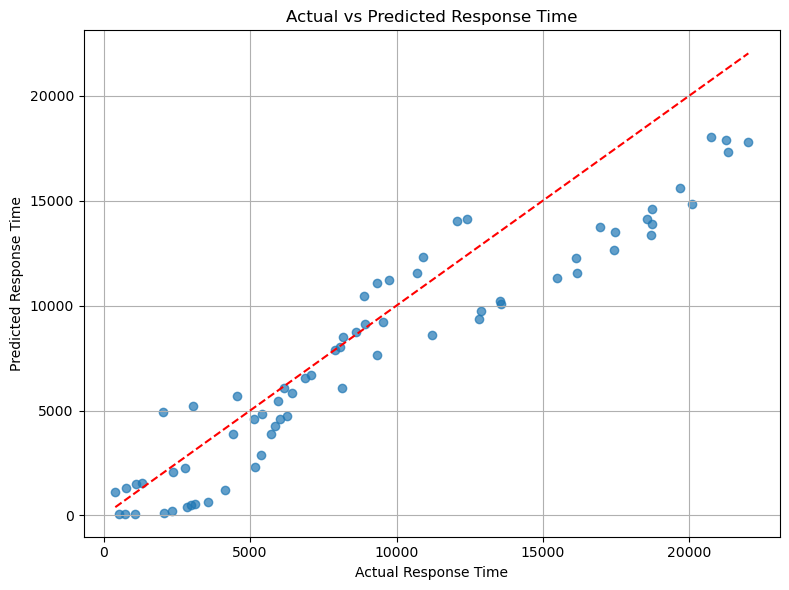

 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


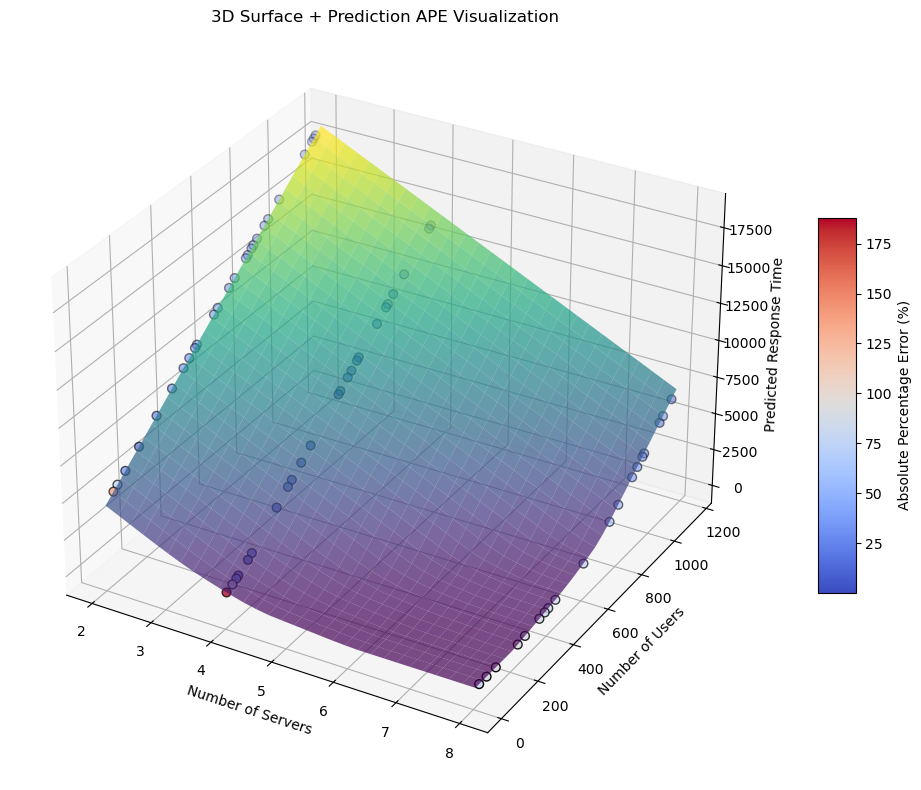

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Load data
data = pd.read_csv("inputfile.csv")

# 2. Identify 2D marginal combinations (corners only)
min_servers = data["num_servers"].min()
max_servers = data["num_servers"].max()
min_users = data["num_users"].min()
max_users = data["num_users"].max()

# Only include rows where BOTH columns are at min/max
marginal_mask = (
    ((data["num_servers"] == min_servers) | (data["num_servers"] == max_servers)) &
    ((data["num_users"] == min_users) | (data["num_users"] == max_users))
)

# 3. Split marginal / non-marginal data
marginal_data = data[marginal_mask]
non_marginal_data = data[~marginal_mask]

X_marginal = marginal_data[["num_servers", "num_users"]]
y_marginal = marginal_data["response_time"]

X_non_marginal = non_marginal_data[["num_servers", "num_users"]]
y_non_marginal = non_marginal_data["response_time"]

# 4. Normalize
X_full = pd.concat([X_marginal, X_non_marginal])
scaler = StandardScaler()
scaler.fit(X_full)

X_marginal_scaled = scaler.transform(X_marginal)
X_non_marginal_scaled = scaler.transform(X_non_marginal)

# 5. Train/test split for non-marginals only
X_rest_train, X_test, y_rest_train, y_test = train_test_split(
    X_non_marginal_scaled, y_non_marginal, test_size=0.2, random_state=42
)

# 6. Merge marginal rows into training
X_train = np.vstack([X_rest_train, X_marginal_scaled])
y_train = pd.concat([y_rest_train, y_marginal])

print(f"Training set includes all {len(X_marginal)} true 2D marginal (corner) rows.")

# 7. Build and train model
model = Sequential()
model.add(Dense(16, input_dim=2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

# 8. Evaluation
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"\nMean Squared Error στο test set: {loss:.4f}")

# 9. Predictions and MAPE
y_pred = model.predict(X_test).flatten()
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

# 10. Denormalize test inputs
X_test_original = scaler.inverse_transform(X_test)

# 11. Comparison DataFrame
comparison_df = pd.DataFrame({
    "num_servers": X_test_original[:, 0],
    "num_users": X_test_original[:, 1],
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Abs_Error": np.abs(y_test.values - y_pred),
    "APE (%)": 100 * np.abs((y_test.values - y_pred) / y_test.values)
})
print("\nSample predictions:\n", comparison_df.head())

# 12. Single prediction example
sample_input = scaler.transform([[3, 200]])
predicted_response_time = model.predict(sample_input)
print(f"\nΠροβλεπόμενος χρόνος απόκρισης: {predicted_response_time[0][0]:.4f} sec")

# 13. 2D Scatter: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Response Time")
plt.ylabel("Predicted Response Time")
plt.title("Actual vs Predicted Response Time")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

# 14. 3D Surface + APE Scatter
num_servers_range = np.linspace(data["num_servers"].min(), data["num_servers"].max(), 30)
num_users_range = np.linspace(data["num_users"].min(), data["num_users"].max(), 30)
grid_servers, grid_users = np.meshgrid(num_servers_range, num_users_range)

grid_inputs = np.column_stack([grid_servers.ravel(), grid_users.ravel()])
grid_inputs_scaled = scaler.transform(grid_inputs)
grid_predictions = model.predict(grid_inputs_scaled).reshape(grid_servers.shape)

APE = 100 * np.abs((y_test.values - y_pred) / y_test.values)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_servers, grid_users, grid_predictions, cmap='viridis', alpha=0.7)

sc = ax.scatter(
    X_test_original[:, 0], X_test_original[:, 1], y_pred,
    c=APE, cmap='coolwarm', s=40, edgecolor='k', label='Prediction APE (%)'
)
fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10, label='Absolute Percentage Error (%)')

ax.set_xlabel("Number of Servers")
ax.set_ylabel("Number of Users")
ax.set_zlabel("Predicted Response Time")
ax.set_title("3D Surface + Prediction APE Visualization")
plt.tight_layout()
plt.show()
